# Physics-informed neural networks (PINNs) to find unknown physics (inverse problem)

Strongly inspired from Ben Moseley, 2022
https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

## Environment set up

First, use the code below to set up your python / Jupyter notebook environment. Using conda is not essential; the required python libraries are listed below.

```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Problem overview

We consider the **Advection-diffusion equation**:

(see Paper text)

## Initial setup

First, we define a few helper functions.

In [21]:
def exact_solution(w0,t):
    "Defines the exact analytical solution "
    u = t - (torch.exp((t-1)/w0) - np.exp(-1/w0))/(1-np.exp(-1/w0))
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Task 1: standard PINN solver using the BC conditions ...

###


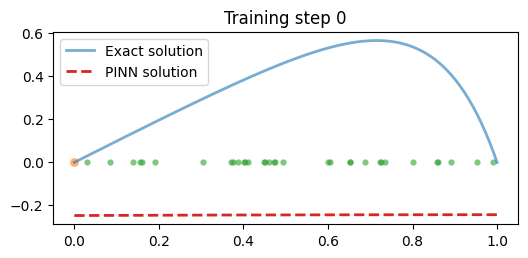

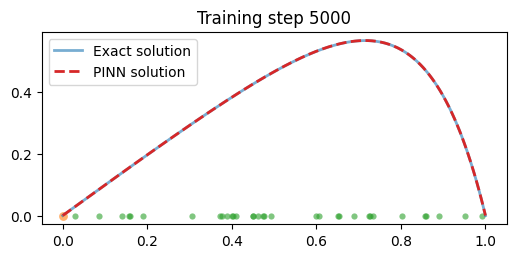

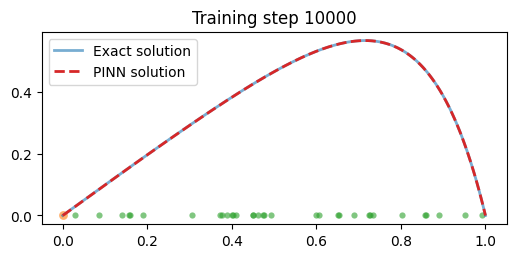

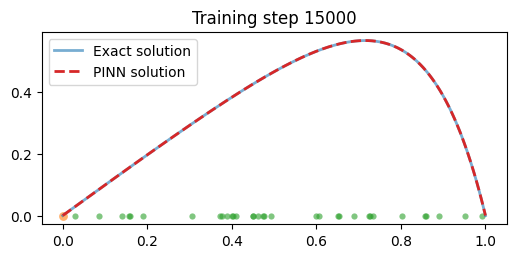

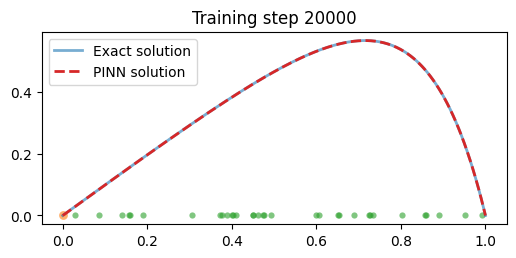

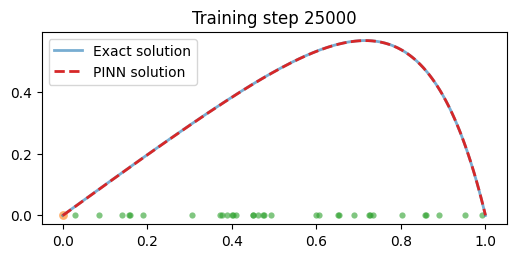

In [26]:
torch.manual_seed(7777)

# define a neural network to train ...............
# One input neuron (for time), one output neuron (elongation), three hiddrn layers having 26 neurons
pinn = FCN(1,1,20,5)

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary2 = torch.tensor(1.).view(-1,1).requires_grad_(True)

# define collocation points over the entire domain, for the physics loss (can be linear or random)
# Note a minimum value is necessary ...........and more points with random !
#t_physics = torch.linspace(0,1,33).view(-1,1).requires_grad_(True)
t_physics = torch.rand(33).view(-1,1).requires_grad_(True)

# train the PINN ...........

# parameters ...
# w0 is the viscosity parameter ...
w0=0.15

# for further testing once trained .....
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(w0, t_test)

# training .....
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

files = []
loss_history = []
loss1_history = []
loss2_history = []
loss3_history = []
mse_history =[]


for i in range(25001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following weighting hyperparameters ....
    lambda1, lambda2 = 1e-0, 3e-1
    
    # compute boundary loss
    # loss1 for BCs ...
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 0)**2    
    u = pinn(t_boundary2)
    loss2 = (torch.squeeze(u) - 0)**2 
        
    # compute physics loss
    # this is loss3 .................
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((dudt - w0* d2udt2 - 1)**2)
    
    # backpropagate joint loss, take optimiser step
    # forming the total loss with weights ......
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()



    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())
        loss3_history.append(loss3.detach())
        loss1_history.append(loss1.detach())    
        
    # plot the result as training progresses    
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        
        plt.scatter(t_boundary.detach()[:,0], 
                    0, s=40, lw=0, color="tab:orange", alpha=0.6)
                    
        #plt.scatter(t_boundary.detach()[:,0], 
                    #torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", linewidth=2,color="tab:blue", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], '--', label="PINN solution", linewidth=2, color="tab:red")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
   

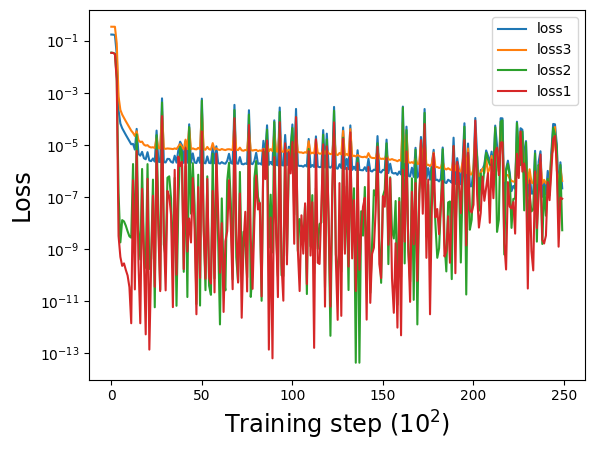

In [27]:

plt.plot(loss_history,label='loss')
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss',fontsize="xx-large")
plt.yscale('log')
plt.legend()


plt.plot(loss3_history, label="loss3")
plt.plot(loss2_history, label="loss2")
plt.plot(loss1_history, label="loss1")
plt.yscale('log')
plt.legend()

## Task 2: train a PINN to invert for underlying parameters




The true value of dissipation = 0.15


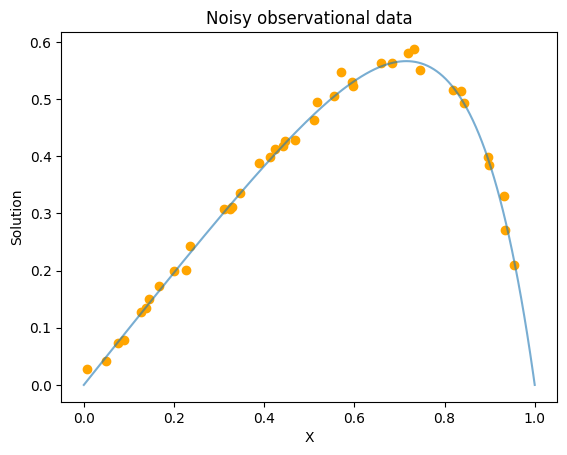

In [30]:
# first, create some noisy observational data .... with given values  w0 ...
# and some noise amplitude noise ....
torch.manual_seed(7777)

noise = 0.01
w0=0.15

print(f"The true value of dissipation = {w0}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(w0, t_obs) + noise*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0], color="orange")
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:blue", alpha=0.6)
plt.xlabel("X")
plt.ylabel("Solution")
plt.show()

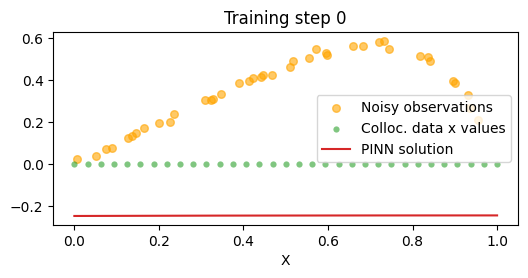

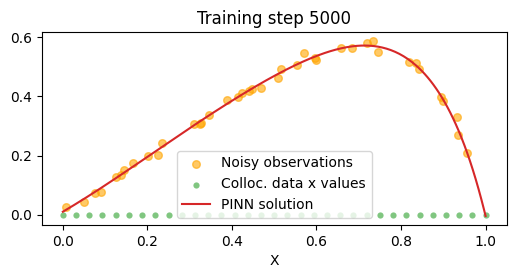

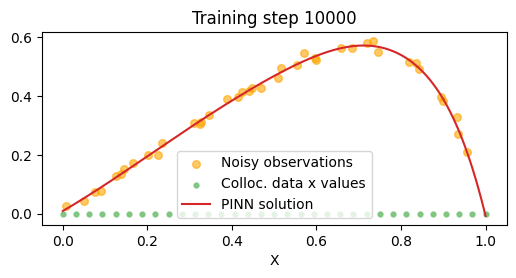

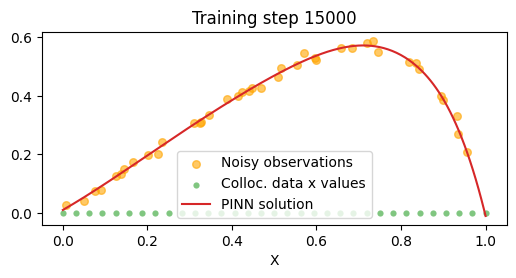

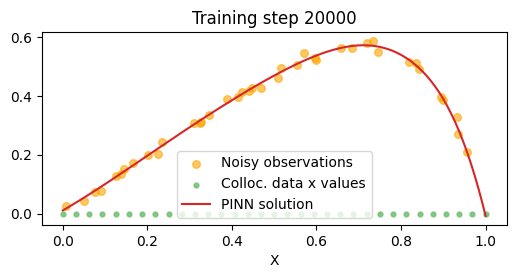

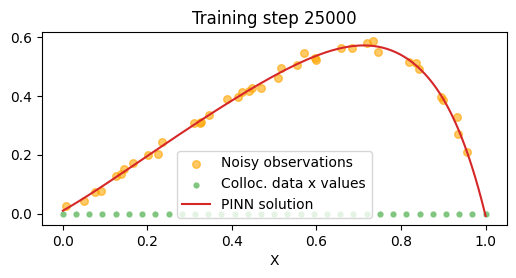

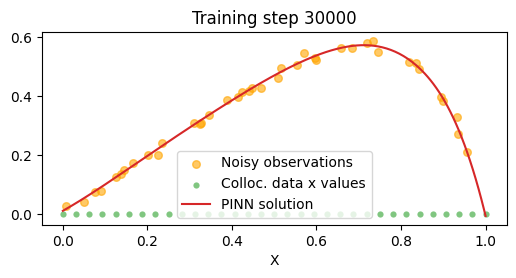

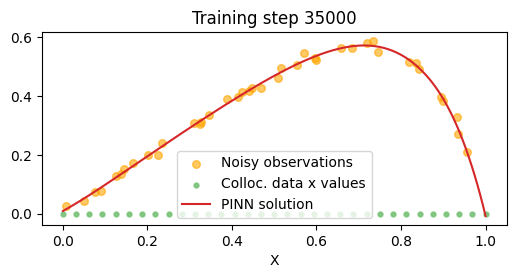

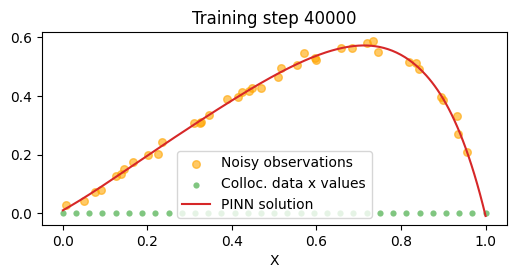

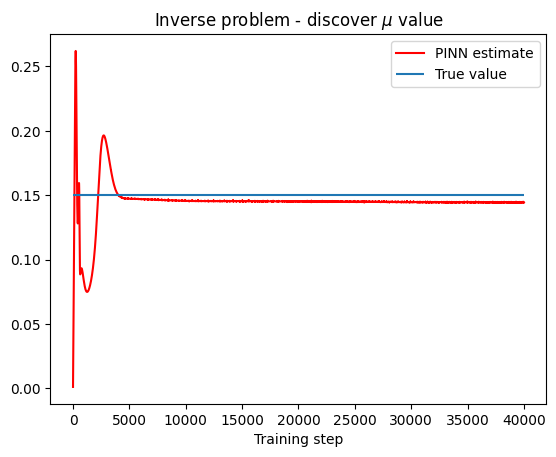

The final predicted value of mu is =
0.14507824182510376


In [33]:
# random initialization of weights .......
torch.manual_seed(7777)

# define a neural network to train ...
pinn = FCN(1,1,20,5)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,33).view(-1,1).requires_grad_(True)
#t_physics = torch.rand(33).view(-1,1).requires_grad_(True)

# train the PINN ............

# treat mu as a learnable parameter ......
# ..............
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimiser
# .........................
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
for i in range(40001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # .........................
    lambda1 = 1e4
    
    # compute physics loss ..................
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((dudt - mu* d2udt2 - 1)**2)
    
    # compute data loss ..............
    # from observed data (training data points) 
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    # ....................
    mus.append(mu.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], s=30,label="Noisy observations", alpha=0.6, color="orange")
        plt.scatter(t_physics.detach()[:,0], 
            torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6, label="Colloc. data x values")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:red")
        plt.title(f"Training step {i}")
        plt.xlabel("X")
        plt.legend()
        plt.show()
        
plt.figure()
plt.title("Inverse problem - discover $\mu$ value")
plt.plot(mus, label="PINN estimate", color='red')
plt.hlines(w0, 0, len(mus), label="True value", color="tab:blue")
plt.legend()
plt.xlabel("Training step")
plt.show()
print(f"The final predicted value of mu is =")
print(mus[20000])